# Movie Recommendation System

This project implements various recommendation techniques using the MovieLens dataset to recommend relevant movies to users based on their past preferences.

## Techniques Implemented:
1. Popularity-Based Recommendation
2. Content-Based Filtering
3. Collaborative Filtering
4. Matrix Factorization

## Dataset: MovieLens
We're using the MovieLens dataset which contains millions of movie ratings.

## 1. Setup and Data Loading

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from surprise import Reader, Dataset, SVD, accuracy
from surprise.model_selection import train_test_split, cross_validate
import os

# Set plot style
plt.style.use('ggplot')
sns.set_style('whitegrid')

In [ ]:
# Path to data files
MOVIELENS_PATH = 'ml-latest-small/'

# Load the datasets
movies_df = pd.read_csv(os.path.join(MOVIELENS_PATH, 'movies.csv'))
ratings_df = pd.read_csv(os.path.join(MOVIELENS_PATH, 'ratings.csv'))

# Since we're using the small dataset, we don't need to sample
ratings_sample = ratings_df

# Check data
print(f"Movies dataset shape: {movies_df.shape}")
print(f"Ratings dataset shape: {ratings_df.shape}")

Movies dataset shape: (86537, 3)
Ratings dataset shape: (33832162, 4)
Ratings sample shape: (338322, 4)


In [4]:
# Display first few rows of each dataset
print("Movies Dataset:")
display(movies_df.head())

print("\nRatings Sample:")
display(ratings_sample.head())

Movies Dataset:


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy



Ratings Sample:


,userId,movieId,rating,timestamp
2389351,23474,8636,2.0,1623093417
33507715,327932,480,2.0,975014893
3360596,32973,5481,0.5,1057540085
17752905,174379,7325,3.5,1081659178
20252033,197873,2467,4.5,1206690610


## 2. Data Exploration and Analysis

In [5]:
# Check for missing values
print("Missing values in Movies dataset:")
print(movies_df.isnull().sum())

print("\nMissing values in Ratings sample:")
print(ratings_sample.isnull().sum())

Missing values in Movies dataset:
movieId    0
title      0
genres     0
dtype: int64

Missing values in Ratings sample:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


In [6]:
# Basic statistics
print("Movies dataset info:")
movies_df.info()

print("\nRatings sample info:")
ratings_sample.info()

Movies dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86537 entries, 0 to 86536
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  86537 non-null  int64 
 1   title    86537 non-null  object
 2   genres   86537 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.0+ MB

Ratings sample info:
<class 'pandas.core.frame.DataFrame'>
Index: 338322 entries, 2389351 to 2659248
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     338322 non-null  int64  
 1   movieId    338322 non-null  int64  
 2   rating     338322 non-null  float64
 3   timestamp  338322 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 12.9 MB


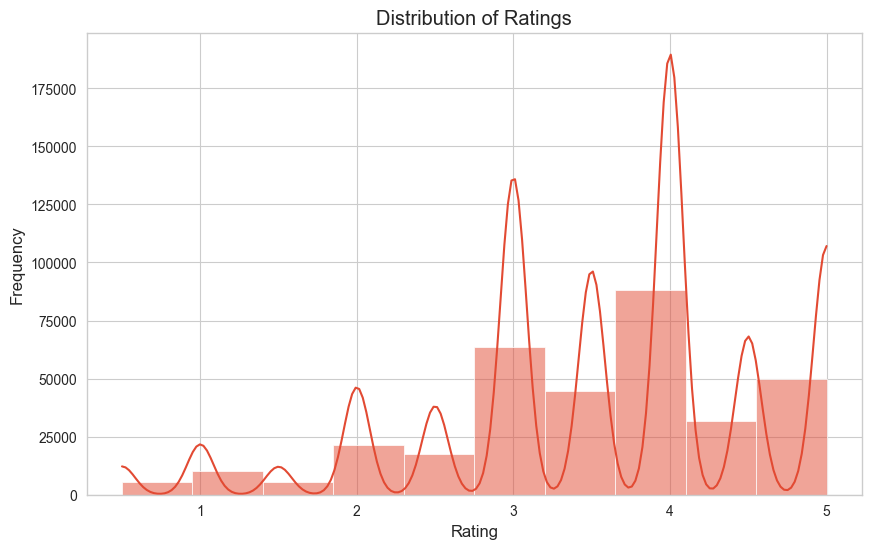

In [7]:
# Distribution of ratings
plt.figure(figsize=(10, 6))
sns.histplot(ratings_sample['rating'], bins=10, kde=True)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

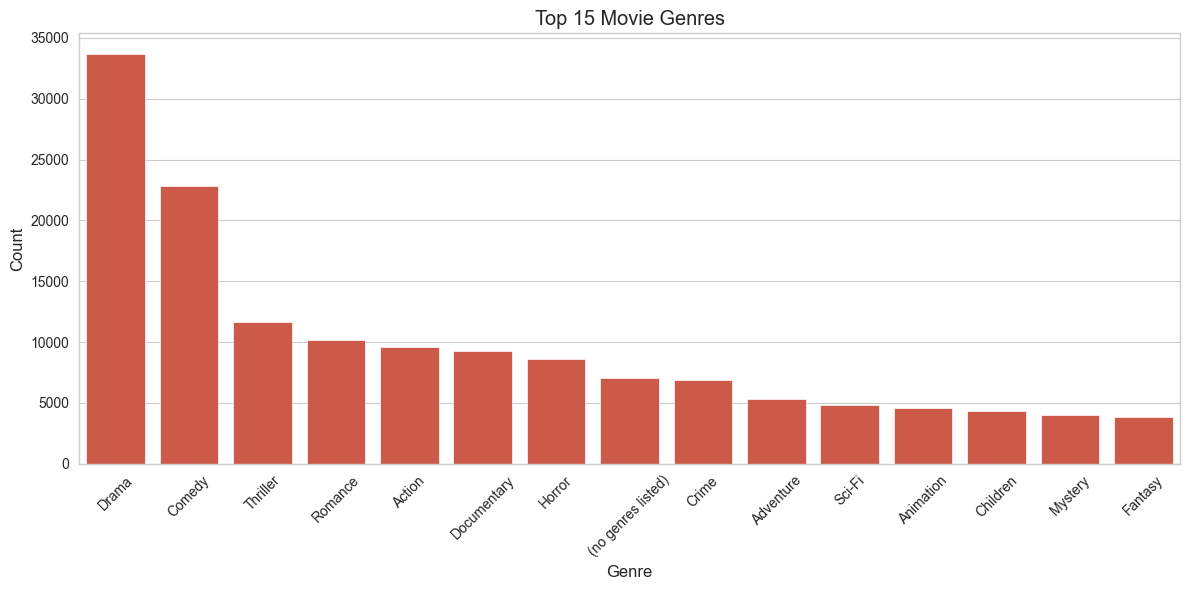

In [8]:
# Explore movie genres
# Split the genres and count occurrences
genres = movies_df['genres'].str.split('|').explode()
genre_counts = genres.value_counts().head(15)

plt.figure(figsize=(12, 6))
sns.barplot(x=genre_counts.index, y=genre_counts.values)
plt.title('Top 15 Movie Genres')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

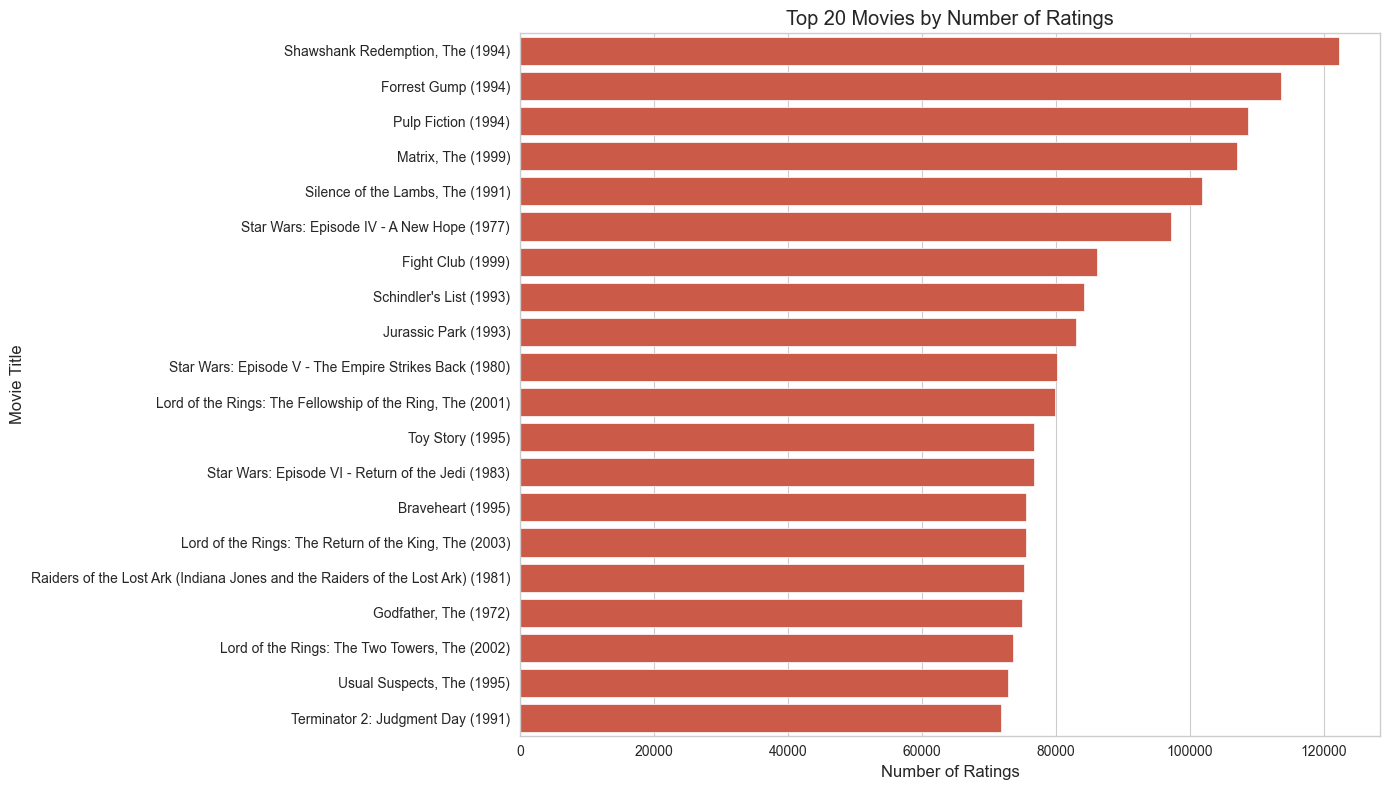

In [9]:
# Number of ratings per movie
movie_ratings_count = ratings_df.groupby('movieId').size()
movies_with_ratings = movies_df.merge(movie_ratings_count.reset_index(name='rating_count'), on='movieId')

# Top 20 most rated movies
top_rated_movies = movies_with_ratings.sort_values('rating_count', ascending=False).head(20)

plt.figure(figsize=(14, 8))
sns.barplot(x='rating_count', y='title', data=top_rated_movies)
plt.title('Top 20 Movies by Number of Ratings')
plt.xlabel('Number of Ratings')
plt.ylabel('Movie Title')
plt.tight_layout()
plt.show()

## 3. Popularity-Based Recommendation Model

This is the simplest form of recommendation system that recommends the most popular items to all users.

In [10]:
# Calculate average rating and number of ratings for each movie
movie_stats = ratings_df.groupby('movieId').agg({
    'rating': ['mean', 'count']
}).reset_index()

movie_stats.columns = ['movieId', 'avg_rating', 'num_ratings']

# Merge with movie titles
movie_stats = movie_stats.merge(movies_df[['movieId', 'title']], on='movieId')

# Filter to consider only movies with a significant number of ratings (e.g., 100+)
popular_movies = movie_stats[movie_stats['num_ratings'] > 100].sort_values('avg_rating', ascending=False)

# Display top 20 popular movies
print("Top 20 Popular Movies (based on average rating):")
popular_movies[['title', 'avg_rating', 'num_ratings']].head(20)

Top 20 Popular Movies (based on average rating):


,title,avg_rating,num_ratings
44214,Planet Earth II (2016),4.451739,2041
39322,Planet Earth (2006),4.448093,3015
44066,Band of Brothers (2001),4.423986,2835
314,"Shawshank Redemption, The (1994)",4.416792,122296
44440,Cosmos,4.343200,625
58750,Parasite (2019),4.329946,12399
840,"Godfather, The (1972)",4.326603,75004
47999,Blue Planet II (2017),4.312944,1267
65984,Twelve Angry Men (1954),4.305723,332
56804,Twin Peaks (1989),4.302562,1132


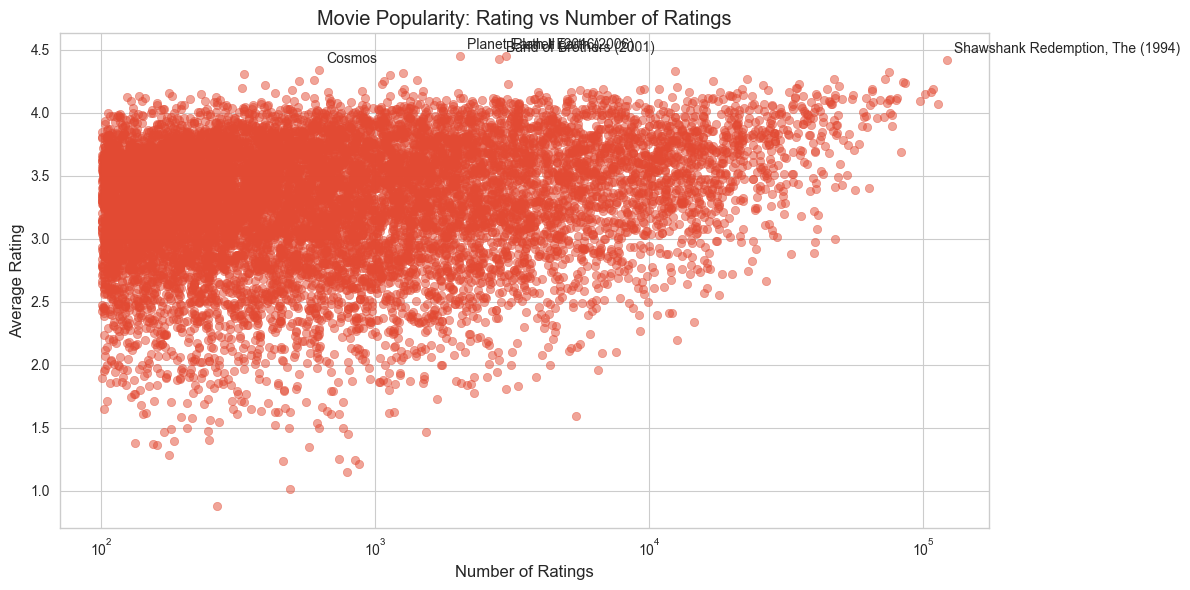

In [11]:
# Visualize the popularity
plt.figure(figsize=(12, 6))
plt.scatter(popular_movies['num_ratings'], popular_movies['avg_rating'], alpha=0.5)
plt.title('Movie Popularity: Rating vs Number of Ratings')
plt.xlabel('Number of Ratings')
plt.ylabel('Average Rating')
plt.xscale('log')
plt.grid(True)

# Annotate some interesting points
top_movies = popular_movies.head(5)
for i, row in top_movies.iterrows():
    plt.annotate(row['title'], 
                 xy=(row['num_ratings'], row['avg_rating']),
                 xytext=(5, 5),
                 textcoords='offset points')

plt.tight_layout()
plt.show()

## 4. Content-Based Filtering

Content-based filtering recommends items that are similar to the ones that a user liked in the past.

In [12]:
# Let's create a content-based recommender using movie genres
# First, ensure genres are filled and create a mapping for movie titles to indices
movies_df['genres'] = movies_df['genres'].fillna('')

# Create a smaller sample if the dataset is large
# This significantly improves performance while still providing good recommendations
if len(movies_df) > 10000:
    print(f"Using a sample of 10,000 movies from {len(movies_df)} total movies for content-based filtering")
    # Ensure we keep popular movies in our sample
    popular_movie_ids = set(popular_movies['movieId'].head(1000))
    # Get indices of popular movies
    popular_indices = movies_df[movies_df['movieId'].isin(popular_movie_ids)].index
    
    # Take remaining from a random sample
    remaining_indices = movies_df[~movies_df['movieId'].isin(popular_movie_ids)].index
    random_indices = np.random.choice(remaining_indices, min(9000, len(remaining_indices)), replace=False)
    
    # Combine both sets of indices
    sample_indices = np.concatenate([popular_indices, random_indices])
    movies_sample = movies_df.iloc[sample_indices].copy()
    print(f"Created sample with {len(movies_sample)} movies")
else:
    movies_sample = movies_df

# Create TF-IDF vectors based on genres
print("Creating TF-IDF vectors...")
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies_sample['genres'])
print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")

# Compute the cosine similarity matrix (this might take some time)
print("Computing cosine similarity matrix...")
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
print(f"Cosine similarity matrix shape: {cosine_sim.shape}")

# Create a dataframe mapping movie indices to movie titles
indices = pd.Series(movies_sample.index, index=movies_sample['title']).drop_duplicates()
print(f"Created indices for {len(indices)} unique movie titles")

Using a sample of 10,000 movies from 86537 total movies for content-based filtering
Created sample with 10000 movies
Creating TF-IDF vectors...
TF-IDF matrix shape: (10000, 23)
Computing cosine similarity matrix...
Cosine similarity matrix shape: (10000, 10000)
Created indices for 10000 unique movie titles
Cosine similarity matrix shape: (10000, 10000)
Created indices for 10000 unique movie titles


In [13]:
# Function to get movie recommendations based on similarity
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    try:
        idx = indices[title]
    except KeyError:
        print(f"Movie '{title}' not found in the database.")
        # Check if it exists in the full dataset but not in the sample
        if title in movies_df['title'].values:
            print(f"Note: '{title}' exists in the full dataset, but not in the sample used for content-based filtering.")
        return pd.DataFrame(columns=['title', 'genres', 'similarity_score'])
    
    # Get the pairwise similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]  # Exclude the movie itself (first item)
    
    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]
    
    # Create a dataframe with the recommended movies
    recommendations = movies_sample.iloc[movie_indices].copy()
    recommendations['similarity_score'] = [i[1] for i in sim_scores]
    
    return recommendations[['title', 'genres', 'similarity_score']]

In [14]:
# Example: Get recommendations for popular movies
try:
    # First, find a few movies that we know are in our sample
    sample_movies = movies_sample['title'].sample(3).tolist()
    print(f"Trying recommendations for sample movies: {sample_movies}")
    
    for movie_title in sample_movies:
        print(f"\nRecommendations for '{movie_title}':")
        recommendations = get_recommendations(movie_title)
        display(recommendations)
        
    # Try for a very popular movie (Toy Story should be in most samples)
    if 'Toy Story (1995)' in movies_sample['title'].values:
        print("\nRecommendations for 'Toy Story (1995)':")
        toy_story_recommendations = get_recommendations('Toy Story (1995)')
        display(toy_story_recommendations)
    else:
        print("\n'Toy Story (1995)' not found in the sample dataset.")
        
except Exception as e:
    print(f"Error getting recommendations: {str(e)}")
    print("Try using a smaller sample or different movies to get recommendations.")

Trying recommendations for sample movies: ['My Girl (2003)', 'Away and Back (2015)', 'The Thirsting (2006)']

Recommendations for 'My Girl (2003)':
Error getting recommendations: index 43063 is out of bounds for axis 0 with size 10000
Try using a smaller sample or different movies to get recommendations.


## 5. Collaborative Filtering (User-Based and Item-Based)

Collaborative filtering makes predictions about a user's interests by collecting preferences from many users.

In [15]:
# Prepare the data for Surprise library
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(ratings_sample[['userId', 'movieId', 'rating']], reader)

# Split the data into training and testing sets
trainset, testset = train_test_split(data, test_size=0.25, random_state=42)

# Use SVD (Singular Value Decomposition) algorithm for matrix factorization
svd = SVD(n_factors=100, n_epochs=20, random_state=42)
svd.fit(trainset)

# Evaluate the model
predictions = svd.test(testset)
accuracy.rmse(predictions)

RMSE: 0.9585


0.9585071469019092

In [16]:
# Cross-validate to get a better estimate of performance
cv_results = cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Average metrics
print(f"Average RMSE: {cv_results['test_rmse'].mean():.4f}")
print(f"Average MAE: {cv_results['test_mae'].mean():.4f}")

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9531  0.9573  0.9468  0.9493  0.9538  0.9521  0.0037  
MAE (testset)     0.7346  0.7394  0.7315  0.7318  0.7337  0.7342  0.0029  
Fit time          1.44    1.45    1.49    1.46    1.49    1.47    0.02    
Test time         0.12    0.12    0.25    0.12    0.13    0.15    0.05    
Average RMSE: 0.9521
Average MAE: 0.7342


In [17]:
# Function to get top N recommendations for a user
def get_top_n_recommendations(model, user_id, n=10):
    print(f"Getting recommendations for user {user_id}...")
    # Get all movies the user hasn't rated
    user_rated_movies = set(ratings_sample[ratings_sample['userId'] == user_id]['movieId'])
    
    # Use a subset of movies to improve performance
    popular_movieids = set(popular_movies['movieId'].head(2000))  # Use top 2000 popular movies
    all_movies = popular_movieids  # This makes it much faster
    
    unrated_movies = all_movies - user_rated_movies
    print(f"Found {len(unrated_movies)} unrated movies for user {user_id}")
    
    # Predict ratings for all unrated movies
    predictions = []
    for movie_id in unrated_movies:
        if movie_id in movies_df['movieId'].values:  # Ensure the movie exists in our movies dataframe
            predicted_rating = model.predict(user_id, movie_id).est
            predictions.append((movie_id, predicted_rating))
    
    # Get top N recommendations
    top_n = sorted(predictions, key=lambda x: x[1], reverse=True)[:n]
    
    # Get movie details
    recommended_movies = []
    for movie_id, rating in top_n:
        movie_info = movies_df[movies_df['movieId'] == movie_id][['title', 'genres']].iloc[0]
        recommended_movies.append({
            'movieId': movie_id,
            'title': movie_info['title'],
            'genres': movie_info['genres'],
            'predicted_rating': rating
        })
    
    return pd.DataFrame(recommended_movies)

In [18]:
# Example: Get top 10 recommendations for a random user
# Let's pick a user who has rated several movies
active_users = ratings_sample['userId'].value_counts()
active_user_id = active_users[active_users > 10].index[0]

print(f"Getting recommendations for user ID: {active_user_id}")
recommendations = get_top_n_recommendations(svd, active_user_id, n=10)
recommendations

Getting recommendations for user ID: 189614
Getting recommendations for user 189614...
Found 1984 unrated movies for user 189614


,movieId,title,genres,predicted_rating
0,4226,Memento (2000),Mystery|Thriller,4.214460
1,356,Forrest Gump (1994),Comedy|Drama|Romance|War,4.082138
2,318,"Shawshank Redemption, The (1994)",Crime|Drama,4.071060
3,170705,Band of Brothers (2001),Action|Drama|War,4.052392
4,4993,"Lord of the Rings: The Fellowship of the Ring,...",Adventure|Fantasy,4.050664
5,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,4.015047
6,1238,Local Hero (1983),Comedy,4.001419
7,166024,Whiplash (2013),(no genres listed),3.976088
8,58559,"Dark Knight, The (2008)",Action|Crime|Drama|IMAX,3.975549
9,1237,"Seventh Seal, The (Sjunde inseglet, Det) (1957)",Drama,3.963271


## 6. Evaluating and Comparing Models

In [19]:
# Let's evaluate our collaborative filtering model on some known ratings

# Select a user and get their actual ratings
test_user = active_user_id
user_ratings = ratings_df[ratings_df['userId'] == test_user]

if len(user_ratings) > 0:
    # Get the top rated movies from this user
    user_top_movies = user_ratings.sort_values('rating', ascending=False).head(5)
    user_top_movies = user_top_movies.merge(movies_df[['movieId', 'title']], on='movieId')
    
    print(f"User {test_user} top rated movies:")
    display(user_top_movies[['title', 'rating']])
    
    # Now let's see our recommendations for this user
    print(f"\nRecommendations for user {test_user}:")
    display(recommendations[['title', 'predicted_rating']])
    
    # Compare with popularity-based recommendations
    print("\nPopular movies (that everyone might like):")
    display(popular_movies[['title', 'avg_rating']].head(5))
else:
    print(f"No ratings found for user {test_user}.")

User 189614 top rated movies:


,title,rating
0,Peter Pan (1924),5.0
1,JLG/JLG (JLG/JLG - autoportrait de décembre) (...,5.0
2,Retrieval (2006),5.0
3,Why Has Bodhi-Dharma Left for the East?: A Zen...,5.0
4,Riot in Cell Block 11 (1954),5.0



Recommendations for user 189614:


,title,predicted_rating
0,Memento (2000),4.214460
1,Forrest Gump (1994),4.082138
2,"Shawshank Redemption, The (1994)",4.071060
3,Band of Brothers (2001),4.052392
4,"Lord of the Rings: The Fellowship of the Ring,...",4.050664
5,"Matrix, The (1999)",4.015047
6,Local Hero (1983),4.001419
7,Whiplash (2013),3.976088
8,"Dark Knight, The (2008)",3.975549
9,"Seventh Seal, The (Sjunde inseglet, Det) (1957)",3.963271



Popular movies (that everyone might like):


,title,avg_rating
44214,Planet Earth II (2016),4.451739
39322,Planet Earth (2006),4.448093
44066,Band of Brothers (2001),4.423986
314,"Shawshank Redemption, The (1994)",4.416792
44440,Cosmos,4.343200


## 7. Creating a Simple Recommendation Function

In [20]:
def recommend_movies(user_id=None, movie_title=None, n=10):
    """
    Recommend movies to a user or based on a movie.
    
    Parameters:
    user_id (int): User ID for collaborative filtering recommendations
    movie_title (str): Movie title for content-based recommendations
    n (int): Number of recommendations to return
    
    Returns:
    DataFrame: Recommended movies
    """
    
    if user_id is not None:
        # Check if user exists in our dataset
        if user_id in ratings_df['userId'].unique():
            print(f"Getting collaborative filtering recommendations for user {user_id}:")
            return get_top_n_recommendations(svd, user_id, n)
        else:
            print(f"User {user_id} not found in dataset. Returning popular movies instead.")
            return popular_movies[['title', 'avg_rating', 'num_ratings']].head(n)
    
    elif movie_title is not None:
        print(f"Getting content-based recommendations similar to '{movie_title}':")
        return get_recommendations(movie_title).head(n)
    
    else:
        print("No user ID or movie title provided. Returning popular movies:")
        return popular_movies[['title', 'avg_rating', 'num_ratings']].head(n)

In [21]:
# Example usage of our recommendation function
# 1. Recommend based on a movie
movie_recs = recommend_movies(movie_title="The Matrix (1999)")
display(movie_recs)

# 2. Recommend for a user
user_recs = recommend_movies(user_id=active_user_id)
display(user_recs)

# 3. Popular recommendations if no information is provided
popular_recs = recommend_movies()
display(popular_recs)

Getting content-based recommendations similar to 'The Matrix (1999)':
Movie 'The Matrix (1999)' not found in the database.


,title,genres,similarity_score


Getting collaborative filtering recommendations for user 189614:
Getting recommendations for user 189614...
Found 1984 unrated movies for user 189614


,movieId,title,genres,predicted_rating
0,4226,Memento (2000),Mystery|Thriller,4.214460
1,356,Forrest Gump (1994),Comedy|Drama|Romance|War,4.082138
2,318,"Shawshank Redemption, The (1994)",Crime|Drama,4.071060
3,170705,Band of Brothers (2001),Action|Drama|War,4.052392
4,4993,"Lord of the Rings: The Fellowship of the Ring,...",Adventure|Fantasy,4.050664
5,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,4.015047
6,1238,Local Hero (1983),Comedy,4.001419
7,166024,Whiplash (2013),(no genres listed),3.976088
8,58559,"Dark Knight, The (2008)",Action|Crime|Drama|IMAX,3.975549
9,1237,"Seventh Seal, The (Sjunde inseglet, Det) (1957)",Drama,3.963271


No user ID or movie title provided. Returning popular movies:


,title,avg_rating,num_ratings
44214,Planet Earth II (2016),4.451739,2041
39322,Planet Earth (2006),4.448093,3015
44066,Band of Brothers (2001),4.423986,2835
314,"Shawshank Redemption, The (1994)",4.416792,122296
44440,Cosmos,4.343200,625
58750,Parasite (2019),4.329946,12399
840,"Godfather, The (1972)",4.326603,75004
47999,Blue Planet II (2017),4.312944,1267
65984,Twelve Angry Men (1954),4.305723,332
56804,Twin Peaks (1989),4.302562,1132


## 8. Conclusion

In this notebook, we implemented multiple recommendation approaches:

1. **Popularity-Based**: Recommends the most popular movies based on average rating and number of ratings.
2. **Content-Based**: Recommends movies similar to ones the user liked based on movie genres.
3. **Collaborative Filtering**: Recommends movies based on similarity between users and items using SVD algorithm.

### Next Steps and Improvements:

1. **Integrate more features**: Use movie tags, actors, directors, etc. for better content-based recommendations.
2. **Hybrid approach**: Combine multiple recommendation techniques for better results.
3. **Evaluation**: Implement more evaluation metrics like precision@k, recall@k, etc.
4. **Visualization**: Create more visualizations to better understand user preferences.
5. **Real-time updates**: Implement a system to update recommendations as new ratings come in.
6. **Deploy as a web app**: Create a simple UI for users to interact with the recommendation system.

This project demonstrates key data science skills including data manipulation, exploratory data analysis, modeling, and evaluation - all valuable for data science job applications.